In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from mocsy import mocsy
import cmocean.cm as cm
from matplotlib import colors

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

coastline_mask = np.loadtxt('coastline_5m.csv', delimiter=',')

In [3]:
def get_xyvals(array):
    valid_points = ~np.isnan(array)
    y, x = np.where(valid_points)  # Get coordinates of valid points
    values = array[valid_points]  # Get the actual values
    return x, y, values

In [4]:
def mocsy_simp(ii, ij, ji, jj, salinity_ds, temp_ds, TA_ds, DIC_ds):
    Tinsitu = np.array(gsw.t_from_CT(salinity_ds, temp_ds, 0))
    Spsu = 35/35.16504 * np.array(salinity_ds)
    TA = np.array(TA_ds)/1000.
    DIC = np.array(DIC_ds)/1000.

    ones = np.ones_like(Spsu.flatten())

    response_tup = mocsy.mvars(temp=Tinsitu.flatten(), sal=Spsu.flatten(), alk=TA.flatten(), 
                           dic=DIC.flatten(), 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    return pH, OmegaA

In [5]:
year = 2023
chem_day = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_chem_00_05_20230101_20231231.nc').isel(depth=4)
phys_day = xr.open_dataset('/ocean/cdonaldson/stair_extractions/SalishSeaCast_day_avg_phys_00_05_20230101_20231231.nc').isel(depth=4)

In [6]:
# chem_year = chem_day.mean(dim='time')
# phys_year = phys_day.mean(dim='time')
phys_test = phys_day.isel(time=0)
phys_test.votemper.shape

(898, 398)

In [7]:
salinity = np.ma.masked_array(phys_day.isel(time=0).vosaline.to_numpy(), mask=coastline_mask)
temperature = np.ma.masked_array(phys_day.isel(time=0).votemper.to_numpy(), mask=coastline_mask)
TA = np.ma.masked_array(chem_day.isel(time=0).total_alkalinity.to_numpy(), mask=coastline_mask)
DIC = np.ma.masked_array(chem_day.isel(time=0).dissolved_inorganic_carbon.to_numpy(), mask=coastline_mask)

salinity_flat = salinity.flatten()
temperature_flat = temperature.flatten()
TA_flat = TA.flatten()
DIC_flat = DIC.flatten()

# ii, ij = 0, 898
# ji, jj = 0, 398

# pH_mon = np.zeros(phys_mon['vosaline'].isel(depth=0).shape)
# OmegaA_mon = np.zeros(phys_mon['vosaline'].isel(depth=0).shape)

# for time_idx in np.arange(len(phys_mon['time'])):
#         print(time_idx)
#         pH, OmegaA = mocsy_simp(ii, ij, ji, jj, idepth, phys_mon.isel(time=time_idx), chem_mon.isel(time=time_idx))
#         print(pH.shape)
#         pH_mon[time_idx] = pH
#         OmegaA_mon[time_idx] = OmegaA

In [8]:
ph_flat, omega_flat = mocsy_simp(0, 898, 0, 398, salinity_flat, temperature_flat, TA_flat, DIC_flat)

In [9]:
ph_flat = np.ma.masked_array(ph_flat, mask=coastline_mask)
omega_flat = np.ma.masked_array(omega_flat, mask=coastline_mask)

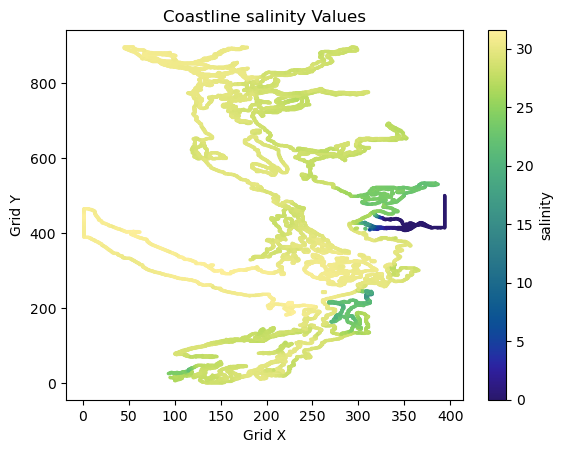

In [10]:
x, y, salinity_vals = get_xyvals(salinity_flat.reshape(898, 398))

plt.scatter(x, y, c=salinity_vals, cmap=cm.haline, s=2)  # Scatter points with color based on values
plt.colorbar(label='salinity')  # Colorbar to represent the values
plt.title('Coastline salinity Values')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

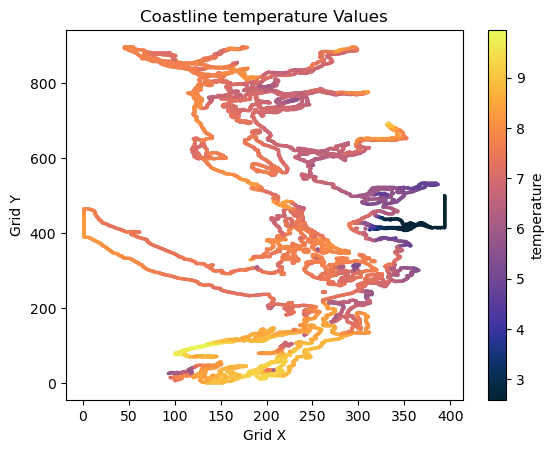

In [11]:
x, y, temperature_vals = get_xyvals(temperature_flat.reshape(898, 398))

plt.scatter(x, y, c=temperature_vals, cmap=cm.thermal, s=2)  # Scatter points with color based on values
plt.colorbar(label='temperature')  # Colorbar to represent the values
plt.title('Coastline temperature Values')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

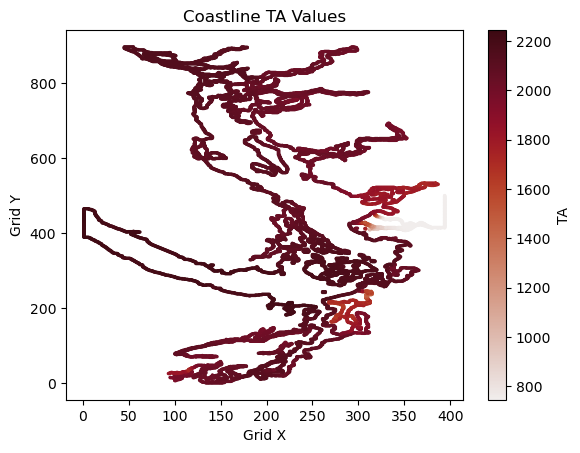

In [12]:
x, y, TA_vals = get_xyvals(TA_flat.reshape(898, 398))

plt.scatter(x, y, c=TA_vals, cmap=cm.amp, s=2)  # Scatter points with color based on values
plt.colorbar(label='TA')  # Colorbar to represent the values
plt.title('Coastline TA Values')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

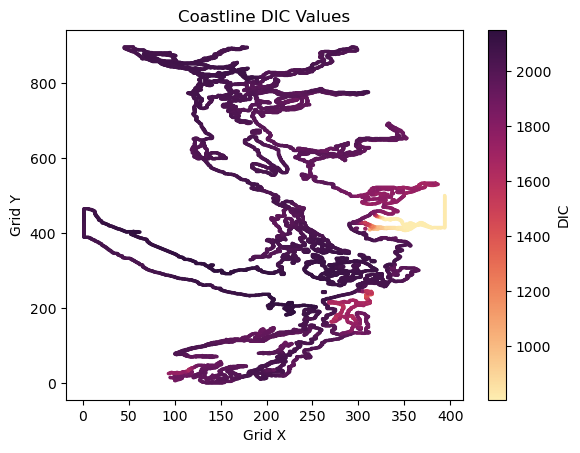

In [13]:
x, y, DIC_vals = get_xyvals(DIC_flat.reshape(898, 398))

plt.scatter(x, y, c=DIC_vals, cmap=cm.matter, s=2)  # Scatter points with color based on values
plt.colorbar(label='DIC')  # Colorbar to represent the values
plt.title('Coastline DIC Values')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

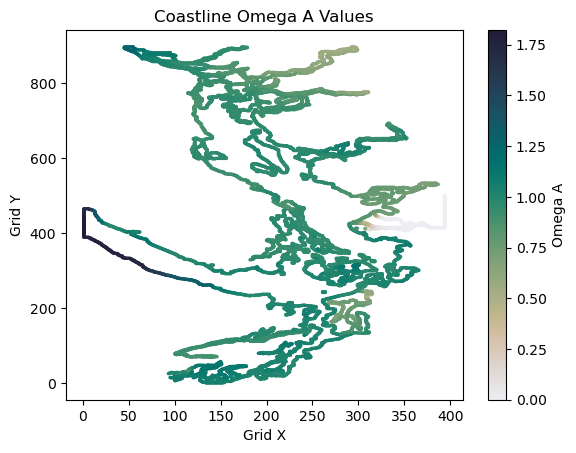

In [14]:
x, y, omegaA_vals = get_xyvals(omega_flat.reshape(898, 398))

plt.scatter(x, y, c=omegaA_vals, cmap=cm.rain, s=2)  # Scatter points with color based on values
plt.colorbar(label='Omega A')  # Colorbar to represent the values
plt.title('Coastline Omega A Values')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

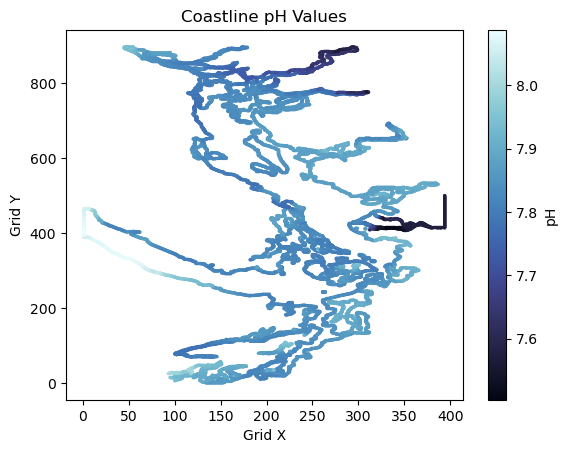

In [15]:
x, y, ph_vals = get_xyvals(ph_flat.reshape(898, 398))

plt.scatter(x, y, c=ph_vals, cmap=cm.ice, s=2)  # Scatter points with color based on values
plt.colorbar(label='pH')  # Colorbar to represent the values
plt.title('Coastline pH Values')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

## Clustering

In [315]:
# Combine the flattened arrays into a single dataset
mask = np.isnan(salinity.filled(np.nan))
data = np.vstack((salinity_flat.filled(np.nan), temperature_flat.filled(np.nan), ph_flat.filled(np.nan))).T
data_clean = data[~np.isnan(data).any(axis=1)]

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_clean)

# Apply K-Means clustering
n_clusters = 6  # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(data_normalized)

clusters_2d = np.full(salinity.shape, np.nan)
clusters_2d[~mask] = clusters

In [316]:
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(-0.5, n_clusters, 1), cmap.N)
cluster_colors = cmap(norm(np.arange(6)))

In [317]:
salinity_vals_only = salinity_flat.filled(np.nan)[~mask.flatten()]
temperature_vals_only = temperature_flat.filled(np.nan)[~mask.flatten()]
ph_vals_only = ph_flat.filled(np.nan)[~mask.flatten()]

param_vals = [salinity_vals_only, temperature_vals_only, ph_vals_only]

In [318]:
salinity_means = np.zeros(n_clusters)
temperature_means = np.zeros(n_clusters)
ph_means = np.zeros(n_clusters)

sal_as_clusters = list()
temp_as_clusters = list()
ph_as_clusters = list()

for i in range(n_clusters):
    sal_mean = salinity_vals_only[clusters == i].mean()
    salinity_means[i] = sal_mean

    temp_mean = temperature_vals_only[clusters == i].mean()
    temperature_means[i] = temp_mean

    ph_mean = ph_vals_only[clusters == i].mean()
    ph_means[i] = ph_mean

    sal_as_clusters.append(salinity_vals_only[clusters == i])
    temp_as_clusters.append(temperature_vals_only[clusters == i])
    ph_as_clusters.append(ph_vals_only[clusters == i])

list_of_params = [sal_as_clusters, temp_as_clusters, ph_as_clusters]

## Cluster Map

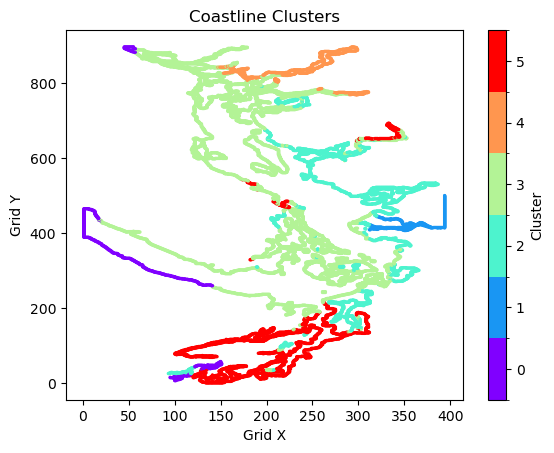

In [319]:
x, y, cluster_vals = get_xyvals(clusters_2d)

plt.scatter(x, y, c=cluster_vals, cmap=cmap, norm=norm, s=2)  # Scatter points with color based on values
plt.colorbar(ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')  # Colorbar to represent the values
plt.title('Coastline Clusters')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

## Property Diagrams

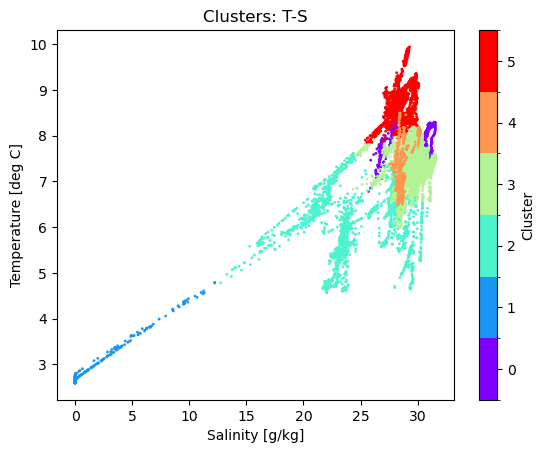

In [320]:
plt.scatter(salinity_vals_only, temperature_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=1)  # Scatter points with color based on values
plt.colorbar(ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')  # Colorbar to represent the values
plt.title('Clusters: T-S')
plt.xlabel('Salinity [g/kg]')
plt.ylabel('Temperature [deg C]')
plt.show()

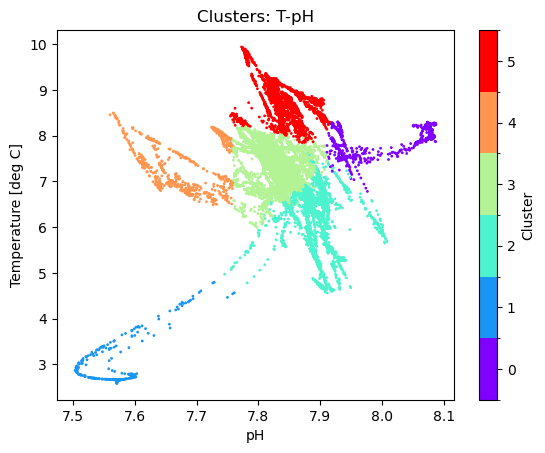

In [321]:
plt.scatter(ph_vals_only, temperature_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=1)  # Scatter points with color based on values
plt.colorbar(ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')  # Colorbar to represent the values
plt.title('Clusters: T-pH')
plt.xlabel('pH')
plt.ylabel('Temperature [deg C]')
plt.show()

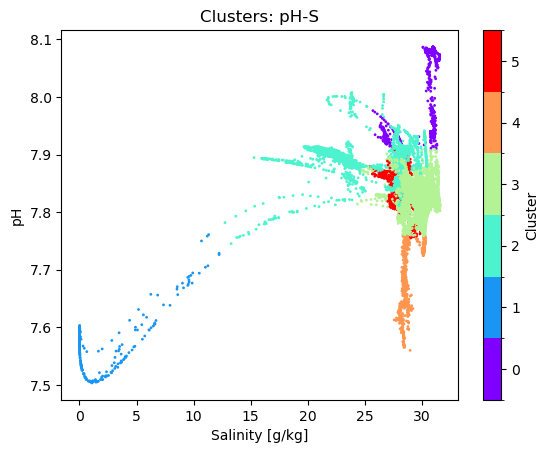

In [322]:
plt.scatter(salinity_vals_only, ph_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=1)  # Scatter points with color based on values
plt.colorbar(ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')  # Colorbar to represent the values
plt.title('Clusters: pH-S')
plt.xlabel('Salinity [g/kg]')
plt.ylabel('pH')
plt.show()

## Box plots

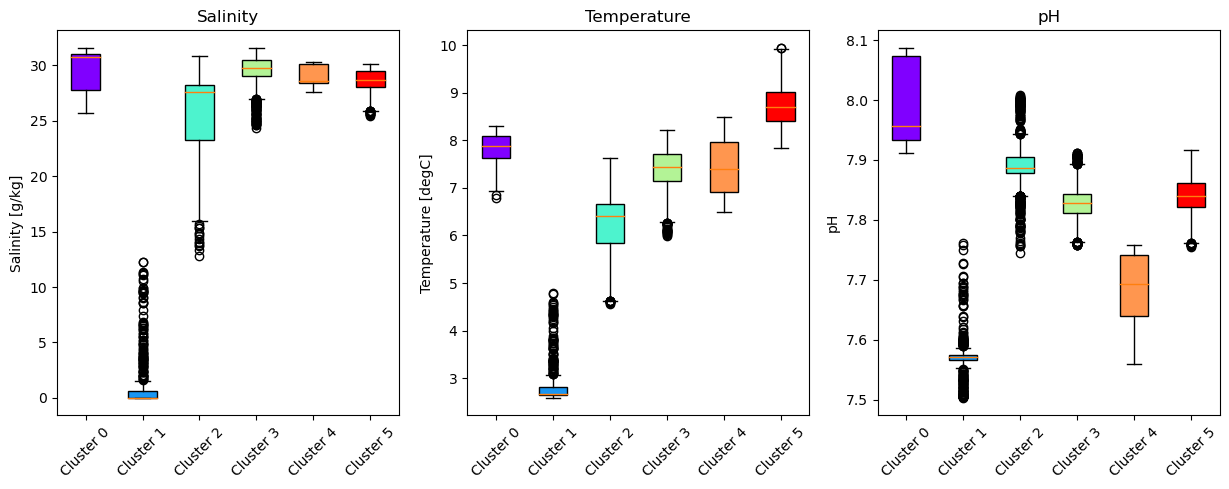

In [323]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

param_titles = ['Salinity', 'Temperature', 'pH']
param_units = ['Salinity [g/kg]', 'Temperature [degC]', 'pH']

for i in range(3):
    boxplot = ax[i].boxplot(list_of_params[i], patch_artist=True)

    ax[i].set_title(param_titles[i])
    ax[i].set_ylabel(param_units[i])
    ax[i].set_xticks(range(1, n_clusters + 1))
    ax[i].set_xticklabels([f'Cluster {j}' for j in range(0, n_clusters)], rotation=45)

    for box, color in zip(boxplot['boxes'], cluster_colors):
        box.set_facecolor(color)

## Summary plot

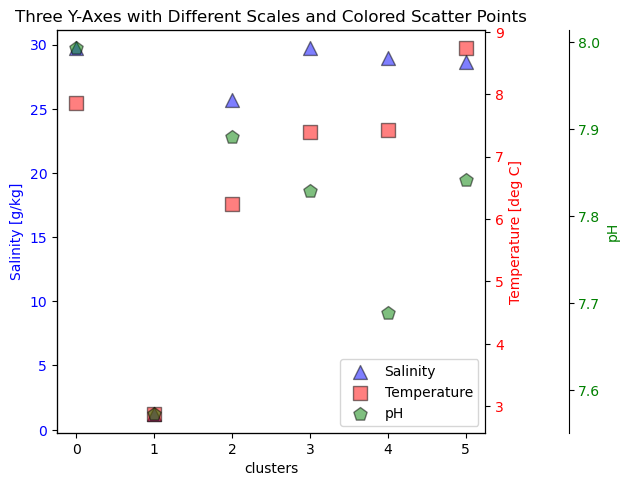

In [324]:
fig, ax1 = plt.subplots()

# salinity
scatter1 = ax1.scatter(range(n_clusters), salinity_means, color='b', label='salinity', marker='^', edgecolor='k', s=100, alpha=0.5)
ax1.set_xlabel('clusters')
ax1.set_ylabel('Salinity [g/kg]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# temperature
ax2 = ax1.twinx()
scatter2 = ax2.scatter(range(n_clusters), temperature_means, color='r', label='temperature', marker='s', edgecolor='k', s=100, alpha=0.5)
ax2.set_ylabel('Temperature [deg C]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# ph
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move third y-axis outward
scatter3 = ax3.scatter(range(n_clusters), ph_means, color='g', label='ph', marker='p', edgecolor='k', s=100, alpha=0.5)
ax3.set_ylabel('pH', color='g')
ax3.tick_params(axis='y', labelcolor='g')

lines = [scatter1, scatter2, scatter3]
labels = ['Salinity', 'Temperature', 'pH']
ax1.legend(lines, labels)

fig.tight_layout()  # Adjust layout to avoid overlap
plt.title('Three Y-Axes with Different Scales and Colored Scatter Points')
plt.show()